## Function to fetch data

In [1]:
import os
import tarfile
from six.moves import urllib

# this is the link github luu data raw.githubusercontent.com va ten ageron/handson-ml2/master
# la repo va branch master
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
# day la duong dan se luu trong may local
HOUSING_PATH = os.path.join('datasets','housing')
# FULL LINK TO DOWNLOAD
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz' 

# de fetch data can 2 link: link download online vs link luu trong may
def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
#     check path luu data co chua, l co return False
#     nen phai su dung not de kich hoat if
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path,exist_ok=True)
#     tao local path de luu data
    tgz_path = os.path.join(housing_path,'housing.tgz')
#     download data ve, para la link download va path luu
    urllib.request.urlretrieve(housing_url,tgz_path)
#     doc file o local path vi da down, extract
    with tarfile.open(tgz_path) as tf:
        tf.extractall(path=housing_path)

fetch_housing_data()

URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

## Function to load data in pandas

In [3]:
import pandas as pd

# do da tai va extract nen pd.read_csv chi can path local la HOUSING_PATH
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path,'housing.csv')
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

Housing_data has 10 cols and 20640 rows:
- Total_bedrooms has non values
- Ocean_proximity is object (categorical)

### Explore categorical value
- Ocean_proximity (top 5 rows has repeated values --> co the dang cate)

In [ ]:
housing['ocean_proximity'].value_counts()

### Explore other numeric value
- Note that non values are ignored
- std measure cac diem data cach nhau nhu the nao
- Percentiles indicates the values below which a given percentage of observations in a group of observations fall e.g(duoi 25% so nha co tuoi la 18yrs)

In [ ]:
housing.describe()

### Another quick way to get a feel of type data --> plot histogram (numerical values)
- A histogram shows the number of instances on vertical axis
- Value range on horizontal axis

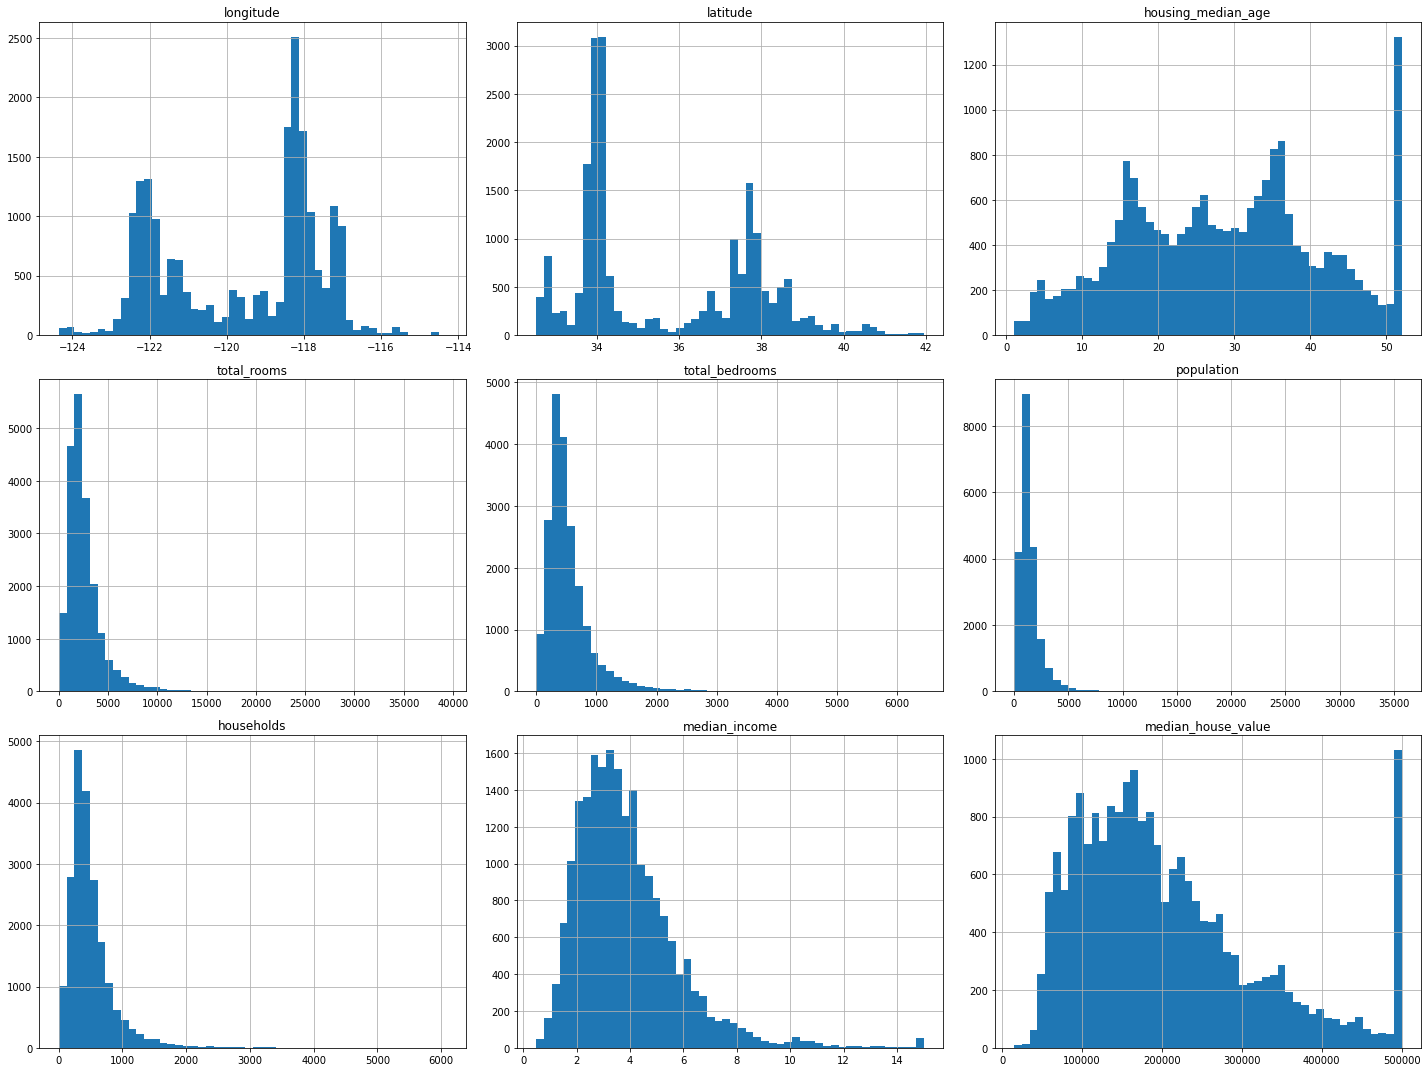

In [4]:
# you can plot 1 attribute in numerical at the time or can call hist()
# method to plot the whole datasets
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50,figsize=(20,15))
plt.tight_layout()
plt.show()

There are a few things to notice in these histograms:
1. Median income attribute doesn't look like in USD dollars. After checking with team collected data (data has been scaled and capped at **15** for **higher median**, and at **0.5** for **lower median**. The numbers represent roughly **tens of thousands of dollars** e.g( **3** means **$30,000**)
2. The housing median age and median hosue value were also capped. That later may be caused serious problem since it is your target (your labels
3. These attributes have very differents scales. **feature scaling**
4. Many histograms are tail-heavy(tail la phan nhon): they extend much father to the right of the median than to the left. **transforming to have bell shaped**

## Create a test set
- Put it a side and never look at it
- Creating a test set is theoretically simple: pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large), and set them aside:

In [5]:
import numpy as np

# function can data, va phan tram cho test set
def split_train_test(data,test_ratio):
#     shuffled indices cua data truoc
    shuffled_indices = np.random.permutation(len(data))
#     tao ra moc cho test size
    test_set_size = int(len(data)*test_ratio)
#     tach ca dataset ra lam 2 tu 0 den test size
    test_indices = shuffled_indices[:test_set_size]
#     tach dataset tu test size den het
    train_indices = shuffled_indices[test_set_size:]
#     tra lai 2 bo data train va test
    return data.iloc[train_indices],data.iloc[test_indices]
    
train_set, test_set = split_train_test(housing,0.2)
print(len(train_set),'train +', len(test_set), 'test')

16512 train + 4128 test


This is working, but with random when you run it again it will generate another test set:
1. Save the test set on the 1st run and load in the subsequence runs
2. Using **random.seed(42)** to generate the same test set over and over again, before calling **random.permutation**
--> Both 2 solutions will break the next time fetch an updated dataset. (load them data moi vao) vi can tinh random data moi phai random vao test voi train set:
- Solution for this is **using instance's identifier (unique id)**

### Create a hash number for id column in housing
- Solution 1 using crc32 (using for both python2-3)

In [6]:
from zlib import crc32

# crc is cyclic redundacy checking (dung de check loi memory trong disk)
# identifier se la id col crc32 check sum byte cua int64(col)
# crc32(np.int64(indentifier)) & 0xffffffff chuyen hoa int sang b32
# test_ratio * 2**32 chuyen hoa 20% so col sang b32
# check thu index col duoc dua vao co nho hon 20% tong dataset

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(ids,test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

- Solution 2 using haslib with hash func **md5**
- Bytearray() returns a btye array object which is an array of given btye
- hash=hash.lib.md5 create a hash number
- .digest() method trong hashlib tra lai enconded data in byte format in range(0,256)

In [7]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

### Create index id for dataset neu dataset khong co
- Cach de nhat su dung dataset.reset_index() --> tao 1 bo dem lam index(neu co the dam bao khong delete row nao chi co append)

In [8]:
# copy ra mot bo data moi voi col index, col_name default index
housing_with_id = housing.reset_index()
# create test set
train_set, test_set = split_train_test_by_id(housing_with_id,0.2,'index')

- Cach khac tao ra index bang nhung attribute khong doi trong dataset (longtitude, latitude) --> nhieu district se co chung dia diem 

In [9]:
# longitude * 1000 de tao nen 3 so 0 placeholder for latitude
housing_with_id['id'] = housing['longitude'] *1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id,.2,'id')

In [ ]:
housing_with_id.head()

- Mot cach nua la su dung train_test_split cua sklearn

In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2,random_state=42)

In [ ]:
test_set.head()

## Visualize to median_income before stratified Shuffle
- Label muon analyse la median_house_value co quan he manh voi median_income
- Muon giu nguyen nhung tinh chat cua median_income trong test set nen su dung them **StratifiedShuffleSplit**
- Muc tieu la de giam **variability** cho ca **median_house_value** va **median_income**

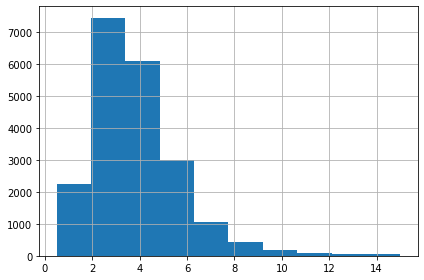

In [11]:
housing['median_income'].hist()
plt.tight_layout()
plt.show()

Truoc khi su dung **StratifiedShuffledSplit** phai chuyen atttribute day ve discrete:
    - chia **median_income** thanh 5 labels 1-->5
    - bins cach nhau 1.5 in range 0-->1.5, 1.5 -->3.0

In [12]:
housing['income_cat'] = pd.cut(housing['median_income'],
                              bins=[0.,1.5,3.0,4.5,6.0,np.inf],
                              labels=[1,2,3,4,5])

## Visualize to median_income after stratified Shuffle

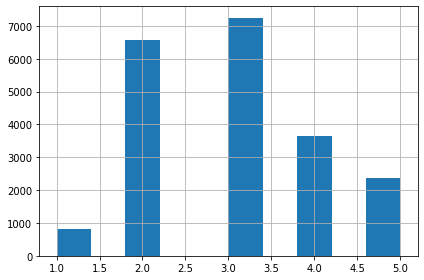

In [13]:
housing['income_cat'].hist()
plt.tight_layout()
plt.show()

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

# initialize model 
split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)
for train_index, test_index in split.split(housing,housing['income_cat']):
    stra_train_set = housing.loc[train_index]
    stra_test_set = housing.loc[test_index]

### Checking for stra_test_set co giu nguyen properties trong housing ban dau khong
- chu y so sanh **stra_test_set** voi its len
- **housing** voi its len

In [15]:
# showing percentage each stratum
stra_test_set['income_cat'].value_counts()/len(stra_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [16]:
housing['income_cat'].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [17]:
def income_cat_proportions(data):
    return data['income_cat'].value_counts()/len(data)

train_set, test_set = train_test_split(housing,test_size=0.2,random_state=42)

# sort_index giup compare dung row voi nhau khi su dung random
compare_pros = pd.DataFrame({
    'Overall':income_cat_proportions(housing),
    'Stratified': income_cat_proportions(stra_test_set),
    'Random': income_cat_proportions(test_set),
}).sort_index()

# -100 de cho ra do sai lech voi data goc housing
compare_pros['Rand. %error'] = 100 * compare_pros['Random'] / compare_pros['Overall'] - 100
compare_pros['Stra. %error'] = 100 * compare_pros['Stratified'] / compare_pros['Overall'] - 100

In [18]:
compare_pros

,Overall,Stratified,Random,Rand. %error,Stra. %error
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


### Sau khi co bo Stra_test_set thi drop income_cat trong stra_set di

In [19]:
for set_ in (stra_train_set, stra_test_set):
    set_.drop('income_cat', inplace=True, axis=1)

## Discover and visualize the data to gain insights
- Lan nay la tim hieu data ve label chu khong phai de tao test set nua

In [20]:
# tao 1 bo copy de thao tac
housing = stra_test_set.copy()

### Trong dataset co thong tin ve dia ly "longitude" "latitude"
- Y hay khi su dung scatterplot de xem cac mat do bao phu cac district nhu lao

[]

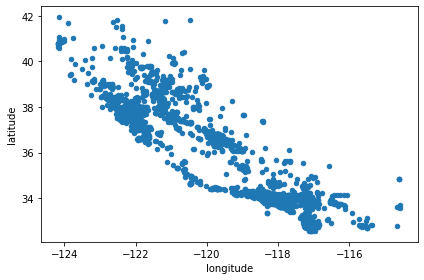

In [21]:
housing.plot(kind='scatter', x='longitude', y='latitude')
plt.tight_layout()
plt.plot()

[]

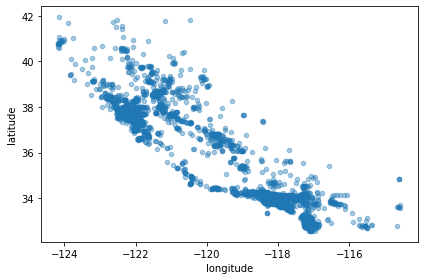

In [22]:
# su dung alpha lam mo di mot so diem, noi len cac quan co nhieu nha
housing.plot(kind='scatter', x='longitude', y='latitude',alpha=0.4)
plt.tight_layout()
plt.plot()

The argument sharex=False fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611 ). Thanks to Wilmer Arellano for pointing it out.
- s option: nhan vao array-like or float, dung radius de the hien do lon population
- c option: the hien thong so cua attribute qua mau

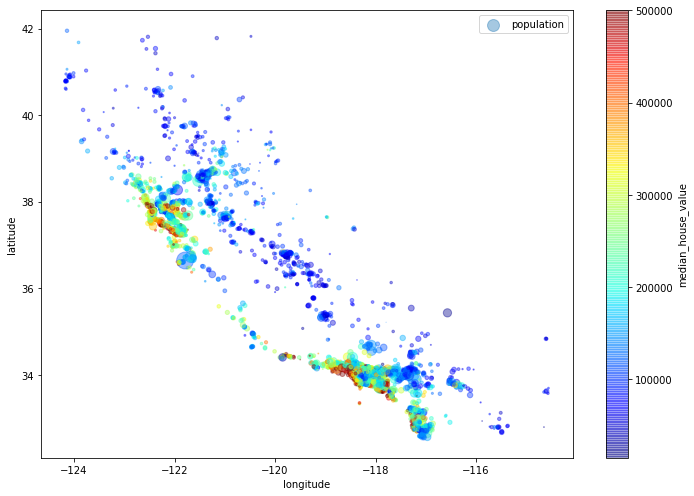

In [23]:
housing.plot(kind='scatter',x='longitude',y='latitude', alpha=0.4,sharex=False,
            s=housing['population']/100, label='population',figsize=(10,7),
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.tight_layout()
plt.show()

## Ve nha test tai cali img